# Определение перспективного тарифа для телеком-компании
Необходимо проанализировать данные небольшой выборки клиентов мобильной сети "Мегалайт" за 2018 год для коррекции рекламного бюджета. Коммерческий департамент хочет понять, какой тариф приносит больше денег. 

**Описание тарифов**

*Тариф «Смарт»*

1.   Ежемесячная плата: 550 рублей
2.   Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.   Стоимость услуг сверх тарифного пакета:
*   минута разговора: 3 рубля
*   сообщение: 3 рубля
*   1 Гб интернет-трафика: 200 рублей

*Тариф «Ультра»*

1.   Ежемесячная плата: 1950 рублей
2.   Включено 3000 минут разговора, 1000 сообщений, 30 Гб интернет-трафика
3.   Стоимость услуг сверх тарифного пакета:
*   минута разговора: 1 рубль
*   сообщение: 1 рубль
*   1 Гб интернет-трафика: 150 рублей

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Описание данных

Таблица `users` (информация о пользователях):

* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tarif` — название тарифного плана

Таблица `calls` (информация о звонках):

* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):

* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):

* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):

* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


## Шаг 1. Загружаем данные

In [1]:
# импортируем бибилиотеки
import pandas as pd
import numpy as np

In [2]:
# чтение данных
df_calls = pd.read_csv('calls.csv')
df_internet = pd.read_csv('internet.csv', index_col='Unnamed: 0')
df_messages = pd.read_csv('messages.csv')
df_tariffs = pd.read_csv('tariffs.csv')
df_users = pd.read_csv('users.csv')

In [3]:
# посмотрим первые строчки таблицы звонков
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
# посмотрим первые строчки таблицы интернет трафика
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [5]:
# посмотрим первые строчки таблицы сообщений
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
# посмотрим первые строчки таблицы тарифа
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
# посмотрим первые строчки таблицы пользователей
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [8]:
# инормация о таблице со звонками
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Таблица `df_calls` имеет 4 столбца и 202607 строк. Тип данных `object`, `int`, `float`.     

Таблица содержит информацию о звонках.  
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

Количество значений в столбцах не различается, пропусков нет.

In [9]:
# инормация о таблице с интернет трафиком
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


Таблица `df_internet` имеет 4 столбца и 149396 строк. Тип данных `object`, `int`, `float`.     

Таблица содержит информацию об интернет-сессиях клиентов.  
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

Количество значений в столбцах одинаковое, пропусков нет.

In [10]:
# информация о таблице с сообщениями
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Таблица `df_messages` имеет 3 столбца и 123036 строк. Тип данных `object`, `int`.     

Таблица содержит информацию о сообщениях.  
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

Количество значений в столбцах одинаковое, пропусков нет.

In [11]:
# инормация о таблице с тарифами
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Таблица `df_tariffs` имеет 8 столбцов и 2 строки. Тип данных большинства столбцов `int` и один столбец `object`.     

Таблица содержит информацию о тарифах `smart` и `ultra`.  
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Количество значений в столбцах одинаковое, пропусков нет.

In [12]:
# инормация о таблице с пользователями
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Таблица `df_users` имеет 8 столбцов и 500 строк. Тип данных `object`, `int`.     

Таблица содержит информацию об интернет-сессиях клиентов.  
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tarif` — название тарифного плана

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

**Вывод** Данных для анализа много. Данные необходимо обработать, поменять типы даных о времени, поизвести допольнительные расчеты, объединить все таблицы в одну.

## Шаг 2. Предобработка данных

**2.1 Отредактируем название столбца в таблице `df_tariffs`**  

Это понадобиться для удобной работы с данными при анализе.

In [13]:
# поменяем название колонки на новое в таблице с тарифами
df_tariffs = df_tariffs.rename(columns={'tariff_name':'tariff'})

In [14]:
df_users.columns

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

**2.2 Приведите данные к нужным типам**

In [15]:
# поменяем тип столбца дата в таблицах, где он есть
df_calls.call_date = df_calls.call_date.apply(pd.to_datetime)
df_internet.session_date = df_internet.session_date.apply(pd.to_datetime)
df_messages.message_date = df_messages.message_date.apply(pd.to_datetime)
df_users.churn_date = df_users.churn_date.apply(pd.to_datetime)
df_users.reg_date = df_users.reg_date.apply(pd.to_datetime)

In [16]:
# проверим изменения
df_calls.dtypes

id                   object
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object

In [17]:
df_messages.dtypes

id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object

In [18]:
df_internet.dtypes

id                      object
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object

In [19]:
df_users.dtypes

user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

In [20]:
# добавим новый стоблец в таблицу с тарифами, переведем Мб в Гб
df_tariffs['gb_per_month_included'] = (df_tariffs['mb_per_month_included'] / 1024).astype('int')

**2.3 Посчитаем для каждого пользователя:**

1. количество сделанных звонков и израсходованных минут разговора по месяцам

In [21]:
# добавим столбец месяц в таблицу звонков
df_calls['month'] = df_calls['call_date'].dt.month

In [22]:
# откруглим длительность звонков до целого числа
df_calls['duration'] = np.ceil(df_calls['duration']).astype('int')

In [23]:
# группируем таблицу по месяцу и индивидуальному номеру звонка, считаем продолжительность и количество звонков
df_calls_group = df_calls.groupby(by=['user_id', 'month'])['duration'].agg({'sum', 'count'}).reset_index()

In [24]:
# зададим новые названия колонок
df_calls_group.columns = ['user_id', 'month', 'count_calls', 'sum_calls']

In [25]:
df_calls_group

,user_id,month,count_calls,sum_calls
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
...,...,...,...,...
3169,1498,10,41,247
3170,1499,9,9,70
3171,1499,10,68,449
3172,1499,11,74,612


2. количество отправленных сообщений по месяцам

In [26]:
# добавим столбец месяц в таблицу сообщения
df_messages['month'] = df_messages['message_date'].dt.month

In [27]:
# группируем таблицу по месяцу и индивидуальному номеру сообщения, считаем количество отправленных смс
df_messages_group = df_messages.groupby(by=['user_id', 'month'])['id'].count().reset_index()

In [28]:
# зададим новые названия колонок
df_messages_group.columns = ['user_id', 'month', 'sms']

In [29]:
df_messages_group

,user_id,month,sms
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


3. объем израсходованного интернет-трафика по месяцам

In [30]:
# добавим столбец месяц в таблицу интернент трафика
df_internet['month'] = df_internet['session_date'].dt.month

In [31]:
# группируем по месяцу и индивидуальному норему интернет сессии, считаем сумму мв 
df_internet_group = df_internet.groupby(by=['user_id', 'month'])['mb_used'].sum().reset_index()

In [32]:
# добавим новый столбец с Гб, переведем Мб в Гб
df_internet_group['gb_used'] = np.ceil(df_internet_group['mb_used'] / 1024).astype('int')

In [33]:
df_internet_group

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3
1,1000,6,23233.77,23
2,1000,7,14003.64,14
3,1000,8,14055.93,14
4,1000,9,14568.91,15
...,...,...,...,...
3198,1498,10,20579.36,21
3199,1499,9,1845.75,2
3200,1499,10,17788.51,18
3201,1499,11,17963.31,18


4. помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)

In [34]:
# объединим таблицу звонков и интернет трафика
df_trafik1 = df_calls_group.merge(df_internet_group, on=['user_id', 'month'], how='outer')

In [35]:
# добавим еще таблицу с сообщениями
df_trafik = df_trafik1.merge(df_messages_group, on=['user_id', 'month'], how='outer')

In [36]:
# добавим в таблицу данные о клиентах
df1 = df_trafik.merge(df_users, on='user_id', how='outer')

In [37]:
# присоединим к общей таблице таблицу с тарифами
df = df1.merge(df_tariffs, on='tariff', how='outer')

In [38]:
df.head(3)

,user_id,month,count_calls,sum_calls,mb_used,gb_used,sms,age,churn_date,city,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,5.0,22.0,159.0,2253.49,3.0,22.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30
1,1000,6.0,43.0,172.0,23233.77,23.0,60.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30
2,1000,7.0,47.0,340.0,14003.64,14.0,75.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   float64       
 2   count_calls            3174 non-null   float64       
 3   sum_calls              3174 non-null   float64       
 4   mb_used                3203 non-null   float64       
 5   gb_used                3203 non-null   float64       
 6   sms                    2717 non-null   float64       
 7   age                    3216 non-null   int64         
 8   churn_date             189 non-null    datetime64[ns]
 9   city                   3216 non-null   object        
 10  first_name             3216 non-null   object        
 11  last_name              3216 non-null   object        
 12  reg_date               3216 non-null   datetime64[ns]
 13  tar

In [40]:
# пропуски заменим 0
df['sum_calls'] = df['sum_calls'].fillna(0)
df['gb_used'] = df['gb_used'].fillna(0)
df['sms'] = df['sms'].fillna(0)

In [41]:
# посчитаем помесячную выручку с каждого пользователя
def profit(row):
     calls = row['sum_calls']
     sms = row['sms']
     gb = row['gb_used']
     min_inc = row['minutes_included']
     sms_inc = row['messages_included']
     gb_inc = row['gb_per_month_included']
     rub_sms = row['rub_per_message']
     rub_min = row['rub_per_minute']
     rub_gb = row['rub_per_gb']
     rub_monthly_fee = row['rub_monthly_fee']
     revenue = 0

     if calls > min_inc:
       revenue = revenue + (calls - min_inc)*rub_min
     elif sms > sms_inc:
       revenue = revenue + (sms - sms_inc)*rub_sms
     elif gb > gb_inc:
       revenue = revenue + (gb - gb_inc)*rub_gb
     revenue = revenue + rub_monthly_fee  
     return revenue       
     
df['profit'] = df.apply(profit, axis=1)

**Вывод** Данные обработаны, таблицы объединены, пропуски заполнены, выручка расчитана. Данные готовы для анализа.

## Шаг 3. Исследовательский анализ данных

Опишием поведение клиентов оператора, исходя из выборки.  
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?  Посчитаем среднее количество, дисперсию и стандартное отклонение.  
Построим гистограммы. Опишием распределения.

**3.1 Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?**

In [42]:
# посчитаем требуемый объем трафика, минут, сообщений каждого трафика в месяц
df_sum = df.pivot_table(index=['month'], columns='tariff', values=['sum_calls', 'gb_used', 'sms'], aggfunc='sum')

In [43]:
# изменим название колонок
df_sum.columns = ['gb_smart_sum', 'gb_ultra_sum', 'sms_smart_sum', 'sms_ultra_sum', 'calls_smart_sum', 'calls_ultra_sum']

In [44]:
df_sum

,gb_smart_sum,gb_ultra_sum,sms_smart_sum,sms_ultra_sum,calls_smart_sum,calls_ultra_sum
month,,,,,,
1.0,297.0,119.0,620.0,304.0,6931.0,3853.0
2.0,687.0,288.0,1397.0,527.0,17324.0,7131.0
3.0,1173.0,653.0,2453.0,1195.0,30034.0,18117.0
4.0,1526.0,933.0,3443.0,1736.0,41119.0,25191.0
5.0,2243.0,1298.0,4762.0,2536.0,54618.0,34192.0
6.0,2616.0,1591.0,5478.0,3505.0,64885.0,40295.0
7.0,3191.0,1866.0,6784.0,4536.0,82079.0,49667.0
8.0,3933.0,2097.0,7905.0,5183.0,99045.0,54653.0
9.0,4262.0,2213.0,8746.0,6013.0,111439.0,62036.0


array([[<AxesSubplot:title={'center':'gb_smart_sum'}>,
        <AxesSubplot:title={'center':'gb_ultra_sum'}>]], dtype=object)

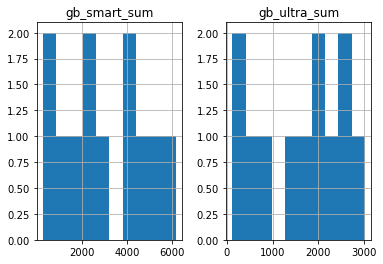

In [45]:
df_sum.hist(column=['gb_smart_sum', 'gb_ultra_sum'])

<AxesSubplot:ylabel='Frequency'>

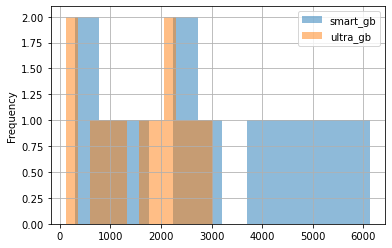

In [46]:
# построим гистограммы для данных двух тарифов
ax = df_sum.plot(kind='hist', y='gb_smart_sum', bins=12, alpha=0.5, label='smart_gb')
df_sum.plot(kind='hist', y='gb_ultra_sum',bins=12, alpha=0.5, label='ultra_gb', ax=ax, grid=True, legend=True)

**Вывод:** чаще всего пользователям тарифа "Смарт" в месяц требуется около 500Гб или 2500Гб интернета. И они не тратят больше 3000 Гб. Пользователи тарифа "Ультра" также чаще всего тратят в мясяц около 500Гб или 2500Гб. И они не тратят больше 6000Гб.

<AxesSubplot:title={'center':'Gb and Month'}, xlabel='month'>

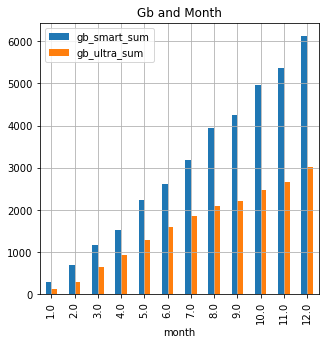

In [47]:
# построим столбчатую диаграмму
df_sum.plot(y=['gb_smart_sum', 'gb_ultra_sum'], kind='bar', figsize=(5,5), grid=True, title='Gb and Month')

<AxesSubplot:ylabel='Frequency'>

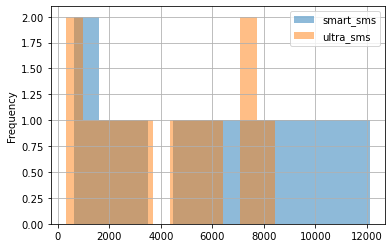

In [48]:
# построим гистограммы для данных двух тарифов
ax = df_sum.plot(kind='hist', y='sms_smart_sum', bins=12, alpha=0.5, label='smart_sms')
df_sum.plot(kind='hist', y='sms_ultra_sum',bins=12, alpha=0.5, label='ultra_sms', ax=ax, grid=True, legend=True)

**Вывод:** чаще всего в месяц пользователям тарифа "Ультра" требиется 1000 смс или около 7000, но 8000 они не используют. Пользователии тарифа "Сматр" чаще всего требуется 1000 сообщений в смс, а максимум не превышает 12000.

<AxesSubplot:title={'center':'Sms and Month'}, xlabel='month'>

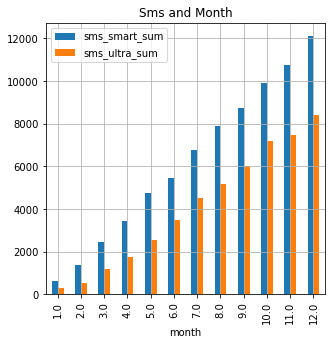

In [49]:
# построим столбчатую диаграмму
df_sum.plot(y=['sms_smart_sum', 'sms_ultra_sum'], kind='bar', figsize=(5,5), grid=True, title='Sms and Month')

<AxesSubplot:ylabel='Frequency'>

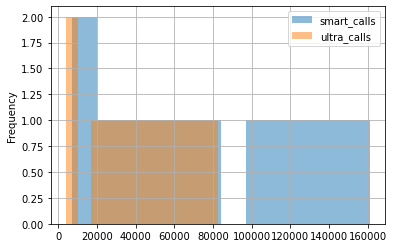

In [50]:
# построим гистограммы для данных двух тарифов
ax = df_sum.plot(kind='hist', y='calls_smart_sum', bins=12, alpha=0.5, label='smart_calls')
df_sum.plot(kind='hist', y='calls_ultra_sum',bins=12, alpha=0.5, label='ultra_calls', ax=ax, grid=True, legend=True)

**Вывод:** чаще всего пользователям тарифа "Смарт" требуется около 2000 мин в мясяц, максимум 23000 мин. Пользователям тарифа "Ультра" требуется чаще всего в месяц около 1000 мин, максимум 12000 мин.

<AxesSubplot:title={'center':'Calls and Month'}, xlabel='month'>

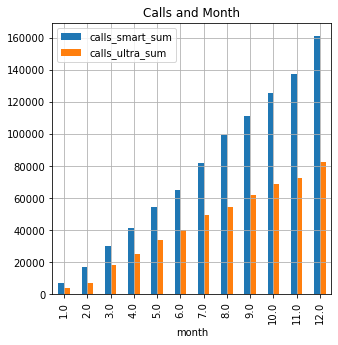

In [51]:
# построим столбчатую диаграмму
df_sum.plot(y=['calls_smart_sum', 'calls_ultra_sum'], kind='bar', figsize=(5,5), grid=True, title='Calls and Month')

**Вывод:** по графикам видно, что пользователи тарифа "Смарт" используют больше интернет-трафика, сообщений, минут на звонки в месяц, чем пользователи тарифа "Ультра". Пользователей тарифа "Смарт" больше.

**3.2 Посчитаем среднее количество минут, сообщений, интерет-трафика в месяц для каждого тарифа**

In [52]:
# расчитаем среднее
df_mean = df.pivot_table(index=['month'], columns='tariff', values=['sum_calls', 'gb_used', 'sms'], aggfunc='mean')

In [53]:
# изменим название колонок
df_mean.columns = ['gb_smart_mean', 'gb_ultra_mean', 'sms_smart_mean', 'sms_ultra_mean', 'calls_smart_mean', 'calls_ultra_mean']

In [54]:
df_mean

,gb_smart_mean,gb_ultra_mean,sms_smart_mean,sms_ultra_mean,calls_smart_mean,calls_ultra_mean
month,,,,,,
1.0,8.735294,13.222222,18.235294,33.777778,203.852941,428.111111
2.0,11.844828,12.000000,24.086207,21.958333,298.689655,297.125000
3.0,15.233766,17.648649,31.857143,32.297297,390.051948,489.648649
4.0,13.625000,16.963636,30.741071,31.563636,367.133929,458.018182
5.0,15.907801,19.373134,33.773050,37.850746,387.361702,510.328358
6.0,15.951220,18.940476,33.402439,41.726190,395.640244,479.702381
7.0,15.875622,20.505495,33.751244,49.846154,408.353234,545.791209
8.0,16.736170,19.598131,33.638298,48.439252,421.468085,510.775701
9.0,16.392308,19.243478,33.638462,52.286957,428.611538,539.443478


array([[<AxesSubplot:title={'center':'gb_smart_mean'}>,
        <AxesSubplot:title={'center':'gb_ultra_mean'}>]], dtype=object)

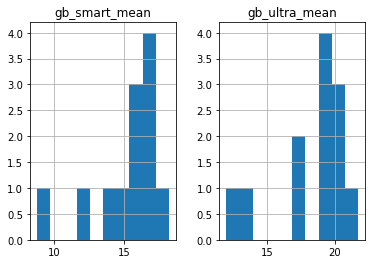

In [55]:
df_mean.hist(column=['gb_smart_mean', 'gb_ultra_mean'])

<AxesSubplot:ylabel='Frequency'>

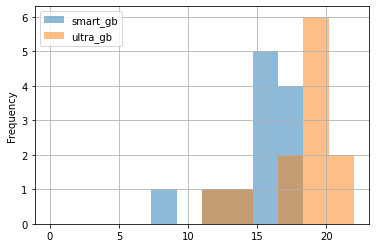

In [56]:
# постороим гистограммы для средних значений интернет-трафика для каждого тарифа
ax = df_mean.plot(kind='hist', y='gb_smart_mean', bins=12, range=(0,22), alpha=0.5, label='smart_gb')
df_mean.plot(kind='hist', y='gb_ultra_mean',bins=12, range=(0,22), alpha=0.5, label='ultra_gb', ax=ax, grid=True, legend=True)

<AxesSubplot:title={'center':'Gb_mean and Month'}, xlabel='month'>

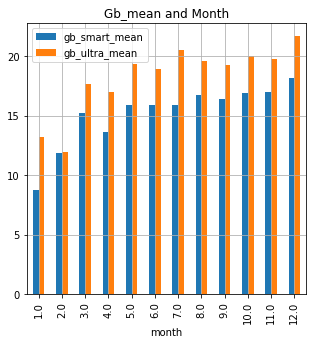

In [57]:
# построим столбчатую диаграмму
df_mean.plot(y=['gb_smart_mean', 'gb_ultra_mean'], kind='bar', figsize=(5,5), grid=True, title='Gb_mean and Month')

**Вывод:** по графикам видно, что пользователи тарифа "Смарт" чаще всего в среднем тратят интернет-трафика около 15Гб или больше, это вы ходит за пределы тарифного плана, значит допольнительные Гб они докупают. Пользователи тарифа "Ультра" чаще всего тратят в среднем в месяц около 20Гб, это не привышает тарифный план.

<AxesSubplot:ylabel='Frequency'>

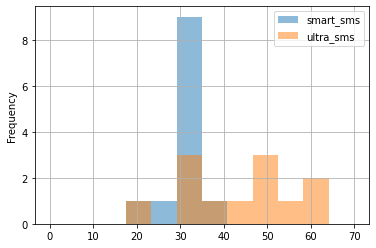

In [58]:
# постороим гистограммы для средних значений количества сообщений для каждого тарифа
ax = df_mean.plot(kind='hist', y='sms_smart_mean', bins=12, range=(0,70), alpha=0.5, label='smart_sms')
df_mean.plot(kind='hist', y='sms_ultra_mean',bins=12, range=(0,70), alpha=0.5, label='ultra_sms', ax=ax, grid=True, legend=True)

**Вывод:** в среднем чаще всего пользователи тарифа "Смарт" тратят около 30 смс, что входит в тарифный план и не выходят за его границы. Пользователи тарифа "Ультра" используют не больше 70 смс, этона много меньше, чем предоставляется тарифом.

<AxesSubplot:title={'center':'Sms_mean and Month'}, xlabel='month'>

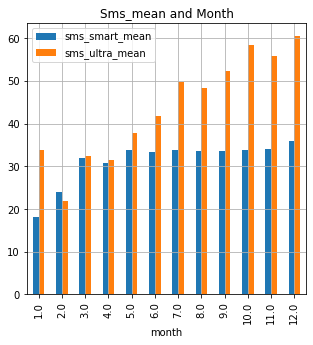

In [59]:
# построим столбчатую диаграмму
df_mean.plot(y=['sms_smart_mean', 'sms_ultra_mean'], kind='bar', figsize=(5,5), grid=True, title='Sms_mean and Month')

<AxesSubplot:ylabel='Frequency'>

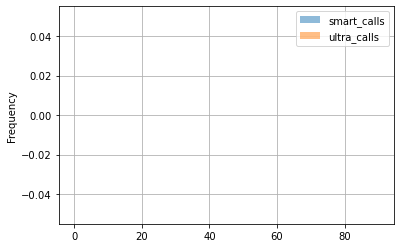

In [60]:
# постороим гистограммы для средних значений минут разговора для каждого тарифа
ax = df_mean.plot(kind='hist', y='calls_smart_mean', bins=12, range=(0,90), alpha=0.5, label='smart_calls')
df_mean.plot(kind='hist', y='calls_ultra_mean',bins=12, range=(0,90), alpha=0.5, label='ultra_calls', ax=ax, grid=True, legend=True)

**Вывод:** Чаще всего пользователи тарифа "Смарт" тратят в месяц в среднем около 60 минут разговора, это не выходит за рамки тарифного плана. Пользователи тарифа "Ультра" чаще всего тратят на раговоры около 70 мин, это также не выходит за рамки тарифного плана.

<AxesSubplot:title={'center':'Calls_mean and Month'}, xlabel='month'>

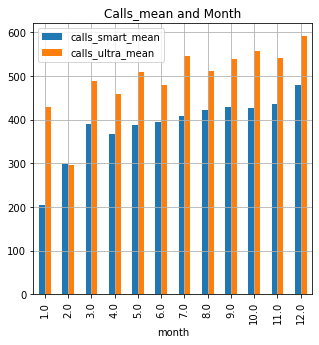

In [61]:
# построим столбчатую диаграмму
df_mean.plot(y=['calls_smart_mean', 'calls_ultra_mean'], kind='bar', figsize=(5,5), grid=True, title='Calls_mean and Month')

**Вывод:** среднии траты по интернет-трафику, сообщениям и звонкам по месяцам выше у тарифа "Ультра". Все пользователи не привышают лимиты установленые их тарифными планами, за исключением пользователей тарифа "Смарт", которые докупают Гб интернета.

**3.3 Посчитаем дисперсию**

In [62]:
# расчет дисперсии
df_var = df.pivot_table(index=['month'], columns='tariff', values=['sum_calls', 'gb_used', 'sms'], aggfunc='var')

In [63]:
# изменение названий колонок
df_var.columns = ['gb_smart_var', 'gb_ultra_var', 'sms_smart_var', 'sms_ultra_var', 'calls_smart_var', 'calls_ultra_var']

In [64]:
df_var

,gb_smart_var,gb_ultra_var,sms_smart_var,sms_ultra_var,calls_smart_var,calls_ultra_var
month,,,,,,
1.0,39.412656,44.444444,262.367201,940.694444,23787.341355,72769.361111
2.0,37.150938,109.130435,473.097701,716.824275,36412.287961,87919.679348
3.0,32.549897,114.345345,718.492481,1732.381381,36823.155161,111384.900901
4.0,31.299550,89.443098,602.139559,1407.287542,34778.207127,71653.870034
5.0,34.370010,95.631389,730.990983,1624.644052,34820.061094,83870.193578
6.0,31.911716,82.394005,806.806374,1986.297619,30742.918861,91535.946500
7.0,33.419453,96.430525,799.887811,2372.042735,32250.269602,94322.278144
8.0,30.041207,105.148298,838.257501,2171.739199,34793.583379,97956.496385
9.0,25.884110,86.255988,790.617820,2152.855530,33535.342723,105716.775286


<AxesSubplot:ylabel='Frequency'>

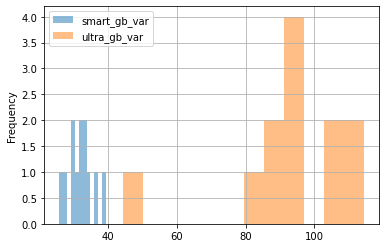

In [65]:
# постороим гистограммы для дисперсии интернет-трафика для каждого тарифа
ax = df_var.plot(kind='hist', y='gb_smart_var', bins=12, alpha=0.5, label='smart_gb_var')
df_var.plot(kind='hist', y='gb_ultra_var',bins=12, alpha=0.5, label='ultra_gb_var', ax=ax, grid=True, legend=True)

<AxesSubplot:title={'center':'Gb_var and Month'}, xlabel='month'>

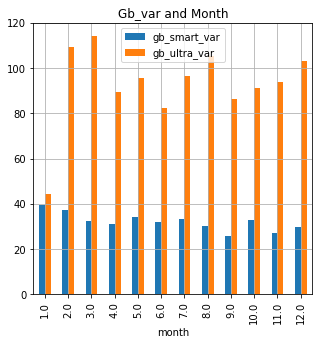

In [66]:
# построим столбчатую диаграмму
df_var.plot(y=['gb_smart_var', 'gb_ultra_var'], kind='bar', figsize=(5,5), grid=True, title='Gb_var and Month')

<AxesSubplot:ylabel='Frequency'>

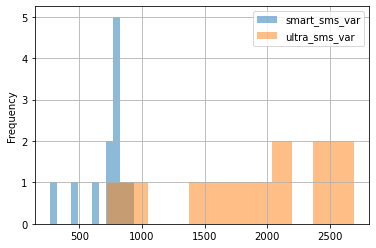

In [67]:
# постороим гистограммы для дисперсии сообщений для каждого тарифа
ax = df_var.plot(kind='hist', y='sms_smart_var', bins=12, alpha=0.5, label='smart_sms_var')
df_var.plot(kind='hist', y='sms_ultra_var',bins=12, alpha=0.5, label='ultra_sms_var', ax=ax, grid=True, legend=True)

<AxesSubplot:title={'center':'Sms_var and Month'}, xlabel='month'>

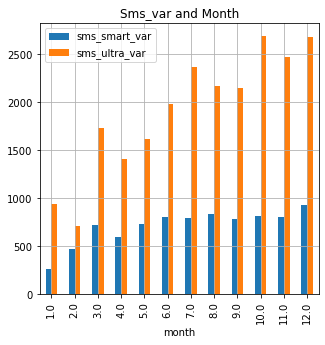

In [68]:
# построим столбчатую диаграмму
df_var.plot(y=['sms_smart_var', 'sms_ultra_var'], kind='bar', figsize=(5,5), grid=True, title='Sms_var and Month')

<AxesSubplot:ylabel='Frequency'>

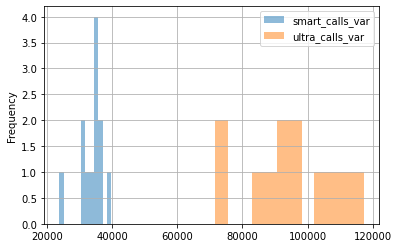

In [69]:
# постороим гистограммы для дисперсии звонков для каждого тарифа
ax = df_var.plot(kind='hist', y='calls_smart_var', bins=12, alpha=0.5, label='smart_calls_var')
df_var.plot(kind='hist', y='calls_ultra_var',bins=12, alpha=0.5, label='ultra_calls_var', ax=ax, grid=True, legend=True)

<AxesSubplot:title={'center':'Calls_var and Month'}, xlabel='month'>

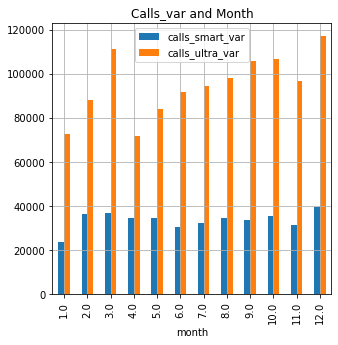

In [70]:
# построим столбчатую диаграмму
df_var.plot(y=['calls_smart_var', 'calls_ultra_var'], kind='bar', figsize=(5,5), grid=True, title='Calls_var and Month')

**3.4 Посчитаем стандартное отклонение**

In [71]:
# расчет стандартного отклонения 
df_std = df.pivot_table(index=['month'], columns='tariff', values=['sum_calls', 'gb_used', 'sms'], aggfunc='std')

In [72]:
#
df_std.columns = ['gb_smart_std', 'gb_ultra_std', 'sms_smart_std', 'sms_ultra_std', 'calls_smart_std', 'calls_ultra_std']

In [73]:
df_std

,gb_smart_std,gb_ultra_std,sms_smart_std,sms_ultra_std,calls_smart_std,calls_ultra_std
month,,,,,,
1.0,6.277950,6.666667,16.197753,30.670742,154.231454,269.757968
2.0,6.095157,10.446551,21.750809,26.773574,190.820041,296.512528
3.0,5.705252,10.693238,26.804710,41.621886,191.893604,333.743765
4.0,5.594600,9.457436,24.538532,37.513831,186.489161,267.682405
5.0,5.862594,9.779130,27.036845,40.306874,186.601343,289.603511
6.0,5.649046,9.077114,28.404337,44.567899,175.336587,302.549081
7.0,5.780956,9.819905,28.282288,48.703621,179.583601,307.119322
8.0,5.480986,10.254184,28.952677,46.601923,186.530382,312.980026
9.0,5.087643,9.287410,28.117927,46.398874,183.126576,325.141162


<AxesSubplot:ylabel='Frequency'>

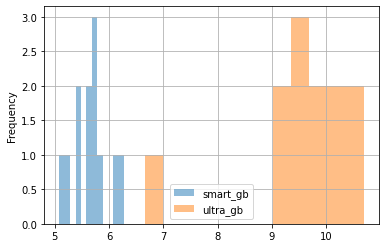

In [74]:
# постороим гистограммы для стандартного отклонения интернет-трафика для каждого тарифа
ax = df_std.plot(kind='hist', y='gb_smart_std', bins=12, alpha=0.5, label='smart_gb')
df_std.plot(kind='hist', y='gb_ultra_std',bins=12, alpha=0.5, label='ultra_gb', ax=ax, grid=True, legend=True)

<AxesSubplot:title={'center':'Gb_std and Month'}, xlabel='month'>

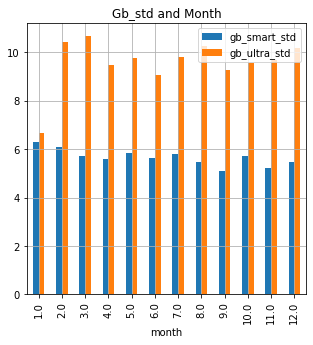

In [75]:
# построим столбчатую диаграмму
df_std.plot(y=['gb_smart_std', 'gb_ultra_std'], kind='bar', figsize=(5,5), grid=True, title='Gb_std and Month')

**Вывод:** в тарифе "Ультра" стандартное отклонение большое, это значит что есть большой разброс в данных, кто-то тратит трафика мало, а кто-то много. Тариф предоставляет большой пакет. По тарифу "Смарт" разброс значений не большой, тарифный план меньше предоставляет трафика, и пользователи в него укладываются.

<AxesSubplot:ylabel='Frequency'>

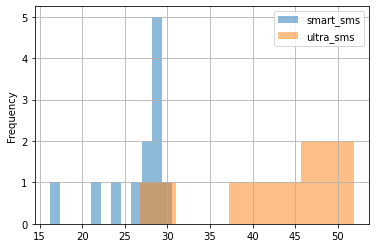

In [76]:
# постороим гистограммы для стандартного отклонения сообщений для каждого тарифа
ax = df_std.plot(kind='hist', y='sms_smart_std', bins=12, alpha=0.5, label='smart_sms')
df_std.plot(kind='hist', y='sms_ultra_std',bins=12, alpha=0.5, label='ultra_sms', ax=ax, grid=True, legend=True)

<AxesSubplot:title={'center':'Sms_std and Month'}, xlabel='month'>

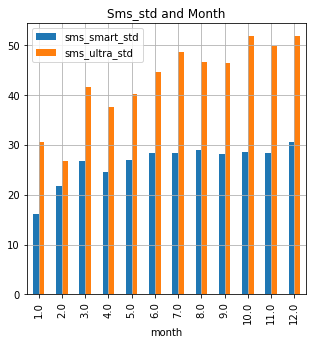

In [77]:
# построим столбчатую диаграмму
df_std.plot(y=['sms_smart_std', 'sms_ultra_std'], kind='bar', figsize=(5,5), grid=True, title='Sms_std and Month')

<AxesSubplot:ylabel='Frequency'>

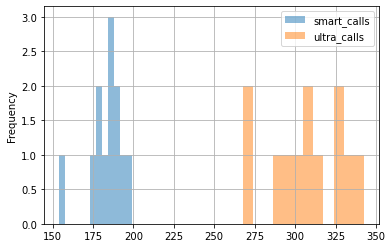

In [78]:
# постороим гистограммы для стандартного отклонения звонков для каждого тарифа
ax = df_std.plot(kind='hist', y='calls_smart_std', bins=12, alpha=0.5, label='smart_calls')
df_std.plot(kind='hist', y='calls_ultra_std',bins=12, alpha=0.5, label='ultra_calls', ax=ax, grid=True, legend=True)

<AxesSubplot:title={'center':'Calls_std and Month'}, xlabel='month'>

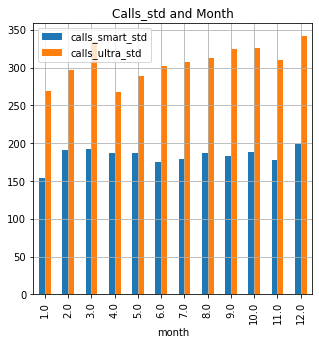

In [79]:
# построим столбчатую диаграмму
df_std.plot(y=['calls_smart_std', 'calls_ultra_std'], kind='bar', figsize=(5,5), grid=True, title='Calls_std and Month')

**3.5 Изучим неагрегированные данные**  
Построим гистограммы для звонков, интернет трафика и сообщений.

<AxesSubplot:>

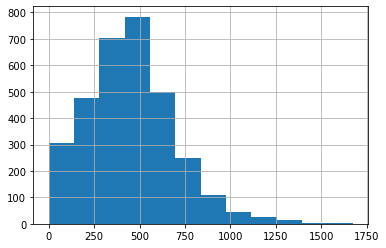

In [80]:
# гистограмма звонков
df['sum_calls'].hist(bins=12)

Большенство пользователей тратит 500мин в месяц, много кто не выговаривают это значение, и совмем мало тех, кто тратит на звонки больше 800мин. Это значит, что пользователи в большенстве своем пратят максимум доступных минут из тарифа сматр. Тариф ультра в своем пакете предоставляет 3000 мин на разговоры, как видно из графика никто из пользователй не добирается до этой отметки.

<AxesSubplot:>

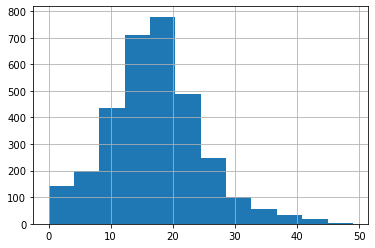

In [81]:
# гистограмма интернет трафика
df['gb_used'].hist(bins=12)

Больше всего пользователей тратят около 15-20 Гб интернет трафика, это больше предоставляемого лимита в тарифе смарт, следовательно допольнительный трафик пользователи преобретают за дополнительную плату. Если рассматривать тариф ультра, который предоставляет 30Гб интернет трафика, то среди пользователей есть те, кто  тратит на интернет больше этого значения, но их совсем не много.

<AxesSubplot:>

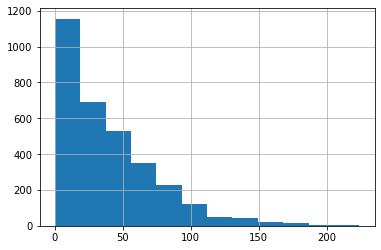

In [82]:
# гистограмма смс
df['sms'].hist(bins=12)

Большенство пользователей тратят в мясяц около 15 сообщений, это меньше чем предоставляет тарифный план смарт, и никто из пользователей не добирается до отметки 1000 смс в тарифе ультра.

## Шаг 4. Проверим гипотезы

**4.1 Гипотеза №1**
Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Нулева гипотеза содержит равенство. Сформулируем ее:
> Средняя выручка пользователей тарифов "Ультра" и "Смарт" одинаковая, или
равны друг другу.

Альтернативная будет звучать:
> Средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются, или не равны друг другу.

In [83]:
from scipy import stats as st

In [84]:
# получим два датасета с данными выручки по тарифам смарт и ультра
df_smart = df.query('tariff == "smart"')['profit']
df_ultra = df.query('tariff == "ultra"')['profit']

In [85]:
alpha = .05
results = st.ttest_ind(df_smart, df_ultra)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
  print('Отвергаем нулевую гипотезу')
else:
  print('Не получилось отвергнуть нулевую гипотезу')  

p-значение: 0.0
Отвергаем нулевую гипотезу


Вывод: нулевая гипотеза отвергнута, значит средняя выручка пользователей тарифов "Смарт" и "Ультра" различается. Гипотеза №1 подтверждается.

**4.2 Гипотеза №2**
Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов



Нулева гипотеза содержит равенство. Сформулируем ее:
> Средняя выручка пользователей из Москвы одинаковая выручке пользователей из других регионов, или равны друг другу.

Альтернативная будет звучать:
> Средняя выручка пользователей из Москвы одинаковая выручке пользователей из других регионов, или не равны друг другу.

In [86]:
# получим два датасета с данными по выручке для пользователей из Москвы и других регионов
df_moscow = df.query('city == "Москва"')['profit']
df_region = df.query('city != "Москва"')['profit']

In [87]:
alpha = .05
results = st.ttest_ind(df_moscow, df_region)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
  print('Отвергаем нулевую гипотезу')
else:
  print('Не получилось отвергнуть нулевую гипотезу')  

p-значение: 0.004014768905757144
Отвергаем нулевую гипотезу


**Вывод:** нулевая гипотеза отвергнута, значит средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Гипотеза №2 подтверждается.

## Шаг 5. Напишите общий вывод

Проанализировав данные можно сказать, что пользователей тарифа "Сматр" больше, и они тратят весь трафик, предоставляемый тарифным планом. Пользователей тарифа "Ультра" меньше, многие не используют свой тарифный план в полной мере. 
Тарифный план "Смарт" лучше, так как польностью соотвествует потребностям клиентов, и они охотнее на него подключаются.



Для компании выгоднее тариф ультра, так как пользователи платят больше, а расходуют меньше.
Но мне кажется, что для рекламной компании лучше превлекать клиентов на тариф смарт, так как есть большое число пользователей которые выходят за рамки тарифа и доплачивают. А так же пользователи могут переходить на более выгодный для себя тариф. 
Если коректировать рекламный бюджет, то наверно лучше потратиться на рекламу тарифа ультра, на дешевый и так подключаться. А с другой стороны, чтобы конкурировать с другими сетями, компании "Мегалайн" лучше привлечь больше пользователей на выгодный тариф смарт.